In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from typing import *
import numpy as np
from functools import partial
from fastprogress import progress_bar
import pandas as pd
import h5py

from lumin.plotting.results import plot_roc

import torch
from torch import Tensor, nn
import torch.nn.functional as F
from torch._vmap_internals import _vmap as vmap

from tomopt.volume import *
from tomopt.muon import *
from tomopt.inference import *
from tomopt.optimisation import *
from tomopt.core import *
from tomopt.utils import *
from tomopt.plotting import *

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
DEVICE = torch.device("cpu")

In [4]:
def get_volume(size: float = 0.1, lwh: Tensor = Tensor([1.0, 1.0, 1.4]), span=2., device: torch.device = torch.device("cpu")) -> Volume:
    def area_cost(x: Tensor) -> Tensor:
        return F.relu(x)

    layers: List[Layer] = []
    n_panels = 4
    layers.append(
        PanelDetectorLayer(
            pos="above",
            lw=lwh[:2],
            z=lwh[2].item(),
            size=0.2,
            panels=[
                DetectorPanel(
                    res=1e4,
                    eff=1,
                    init_xyz=(0., 0., lwh[2].item() - (i * (0.2) / n_panels)),
                    init_xy_span=(span, span),
                    area_cost_func=area_cost,
                    device=device,
                )
                for i in range(n_panels)
            ],
        )
    )
    for z in np.round(np.arange(lwh[2] - 0.2, 0.2, -size), decimals=2):
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=device))
    layers.append(
        PanelDetectorLayer(
            pos="below",
            lw=lwh[:2],
            z=0.2,
            size=0.2,
            panels=[
                DetectorPanel(
                    res=1e4,
                    eff=1,
                    init_xyz=(0., 0., 0.2 - (i * (0.2) / n_panels)),
                    init_xy_span=(span, span),
                    area_cost_func=area_cost,
                    device=device,
                )
                for i in range(n_panels)
            ],
        )
    )

    return Volume(nn.ModuleList(layers))

In [5]:
volume = get_volume()

In [6]:
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([1.4000]), and xy span tensor([2., 2.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([1.3500]), and xy span tensor([2., 2.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([1.3000]), and xy span tensor([2., 2.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([1.2500]), and xy span tensor([2., 2.])
      )
    )
    (1): PassiveLayer located at z=tensor([1.2000])
    (2): PassiveLayer located at z=tensor([1.1000])
    (3): PassiveLayer located at z=tensor([1.])
    (4): PassiveLayer located at z=tensor([0.9000])
    (5): PassiveLayer located at z=tensor([0.8000])
    (6): PassiveLayer located at z=tensor([0.7000])
    (7): PassiveLayer located at z=te

# Volume classifier

In [7]:
from tomopt.benchmarks.ladle_furnace import *

# Optimisation

In [8]:
volume.get_cost()

tensor(32., grad_fn=<AddBackward0>)

In [9]:
passives = PassiveYielder(LadleFurnacePassiveGenerator(volume), n_passives=4)

In [10]:
from tomopt.optimisation import NoMoreNaNs, PanelMetricLogger, CostCoefWarmup, PanelOptConfig, MuonResampler

In [11]:
wrapper = PanelVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xy_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=LadleFurnaceIntClassLoss(use_mse=True, target_budget=None),
                             partial_volume_inferer=partial(LadleFurnaceFillLevelInferrer, partial_x0_inferer=PanelX0Inferer, output_probs=False))

## Initial performance

In [12]:
test_passives = PassiveYielder(LadleFurnacePassiveGenerator(volume), n_passives=200)

In [13]:
preds = wrapper.predict(test_passives,
                n_mu_per_volume=250,
                mu_bs=250,
                cbs=[MuonResampler()],
                pred_cb=VolumeTargetPredHandler())

/Users/giles/cernbox/mode_muon_tomography/tomopt/inference/scattering.py:329: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  idxs = torch.combinations(torch.arange(0, unc.shape[-1]), with_replacement=True)


In [14]:
df_start = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])

In [15]:
df_start.gen_target

0      1.002456
1      0.743948
2      1.054893
3      1.014637
4      0.563929
         ...   
195    0.564391
196    0.403803
197    0.500848
198    0.709646
199    0.828734
Name: gen_target, Length: 200, dtype: float32

In [16]:
volume.passive_size*((df_start.gen_target/volume.passive_size)//1)

0      1.0
1      0.7
2      1.0
3      1.0
4      0.5
      ... 
195    0.5
196    0.4
197    0.5
198    0.7
199    0.8
Name: gen_target, Length: 200, dtype: float32

In [17]:
df_start['gen_target'] = volume.passive_size*((df_start.gen_target/volume.passive_size)//1)

In [18]:
df_start

,pred,gen_target
0,0.8,1.0
1,0.5,0.7
2,0.9,1.0
3,0.9,1.0
4,0.9,0.5
...,...,...
195,0.6,0.5
196,0.5,0.4
197,0.9,0.5
198,0.9,0.7


In [19]:
df_start['mse'] = (df_start.gen_target-df_start.pred)**2

In [20]:
df_start.mse.mean()

0.0627

## Optimise

In [21]:
wrapper.partial_volume_inferer = partial(LadleFurnaceFillLevelInferrer, partial_x0_inferer=PanelX0Inferer, output_probs=True)

CostCoefWarmup: Freezing optimisation for 5 epochs
PanelOptConfig: Freezing optimisation for 5 epochs


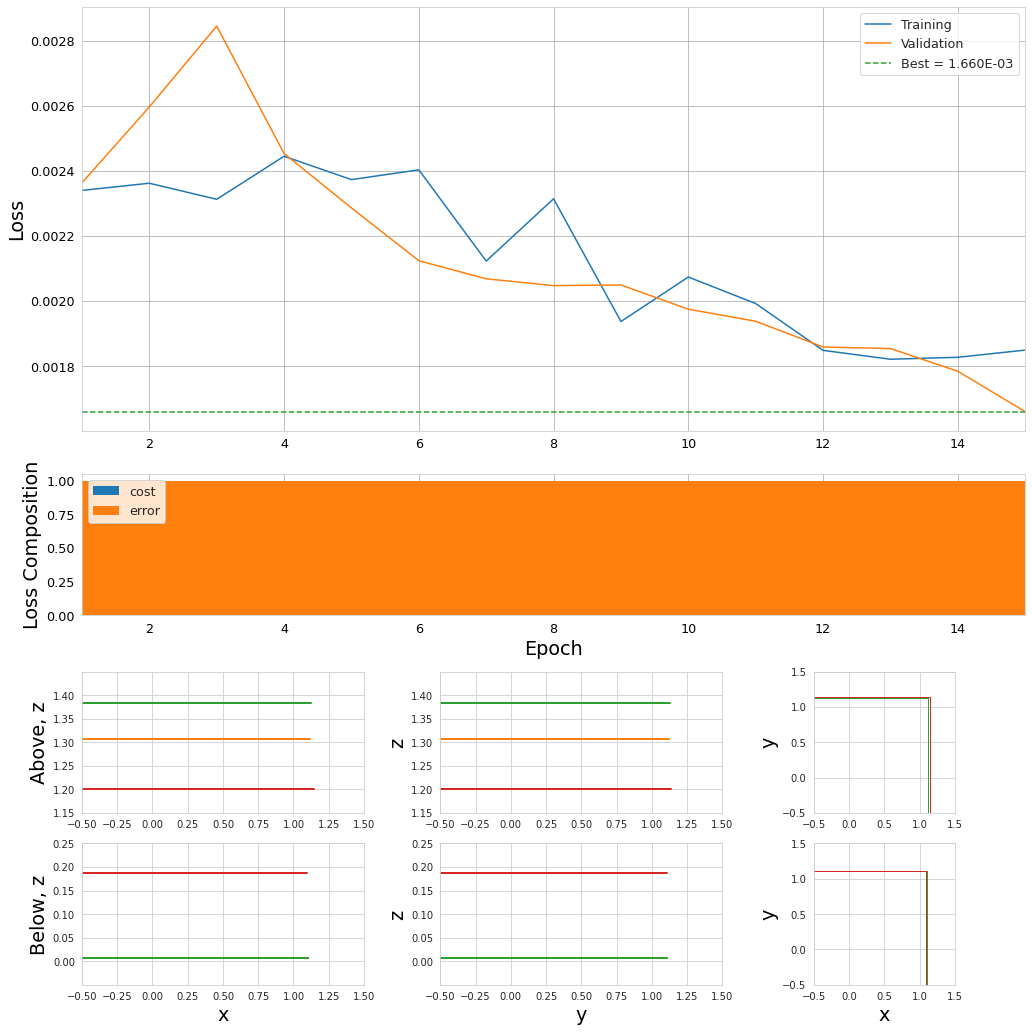

Automatically setting cost coefficient to 0.0024571362882852554


/Users/giles/cernbox/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:220: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


CostCoefWarmup: Warmed up, average error = tensor([0.0024])
PanelOptConfig: Optimiser warm-up completed
+-------------+---------------+--------------------+
|    Param    |  Median Grad  |         LR         |
+-------------+---------------+--------------------+
|  xy_pos_opt |  0.0005153215 | 19.405361414618696 |
|  z_pos_opt  |  0.001686649  | 2.964457844156678  |
| xy_span_opt | 0.00016579966 | 60.31375391906345  |
+-------------+---------------+--------------------+


<Figure size 1024x1024 with 0 Axes>

In [22]:
_ = wrapper.fit(n_epochs=15,
                passive_bs=4,
                n_mu_per_volume=250,
                mu_bs=250,
                trn_passives=passives,
                val_passives=passives,
                cbs=[CostCoefWarmup(n_warmup=5), PanelOptConfig(n_warmup=5, xy_pos_rate=0.01, z_pos_rate=0.005, xy_span_rate=0.01), MuonResampler(), NoMoreNaNs(),PanelMetricLogger()])

In [23]:
volume.get_cost()

tensor(34.5855, grad_fn=<AddBackward0>)

## Optimised performance

In [34]:
wrapper.partial_volume_inferer = partial(LadleFurnaceFillLevelInferrer, partial_x0_inferer=PanelX0Inferer, output_probs=False)

In [35]:
preds = wrapper.predict(test_passives,
                n_mu_per_volume=250,
                mu_bs=250,
                cbs=[MuonResampler()],
                pred_cb=VolumeTargetPredHandler())

In [36]:
df_end = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])

In [37]:
df_end['gen_target'] = volume.passive_size*((df_end.gen_target/volume.passive_size)//1)

In [38]:
df_end['mse'] = (df_end.gen_target-df_end.pred)**2

In [39]:
df_end.mse.mean()

0.06385